In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [124]:
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [3]:
df = pd.read_csv('clean_house_data.csv',keep_default_na=False)

In [4]:
df.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
154,30,RM,84.0,11340,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,0,3,2006,WD,Family,125000
1256,20,RL,91.0,14303,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,8,2008,WD,Normal,301500
883,75,RL,60.0,6204,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,3,2006,WD,Normal,118500
330,90,RL,69.0,10624,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,11,2007,WD,Normal,119000
1372,60,RL,75.0,9750,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,6,2006,WD,Normal,274300


In [5]:
df.shape

(1460, 75)

In [6]:
numeric_cols = list(df.select_dtypes(include=['int','float']).columns)
category_cols = list(df.select_dtypes(include=['object']).columns)

In [7]:
ordinal_cols = [
    'OverallQual','OverallCond',
    'ExterQual','ExterCond',
    'BsmtQual','BsmtCond',
    'HeatingQC','KitchenQual','FireplaceQu',
    'GarageQual','GarageCond'
]

In [8]:
category_cols = [c for c in category_cols if c not in ordinal_cols]

In [9]:
numeric_cont = []
numeric_ordinal = []

for col in numeric_cols:
    if col in ordinal_cols:
        numeric_ordinal.append(col)
    else:
        if df[col].nunique() < 15:
            numeric_ordinal.append(col)
        else:
            numeric_cont.append(col)

In [10]:
ordinal_cols = df[ordinal_cols].select_dtypes(include='object').columns.tolist()

## Kruskal test for categorical columns

In [11]:
category_cols

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'GarageFinish',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [12]:
def kruskal_for_categorical(df, cat_col, target='SalePrice', min_group_size=5):
    groups = []
    for level in df[cat_col].dropna().unique():
        vals = df[df[cat_col] == level][target]
        if len(vals) >= min_group_size:
            groups.append(vals)
    if len(groups) <= 1:
        return None
    h_stat, p_val = kruskal(*groups)
    return h_stat, p_val

In [13]:
krus_results = []

for col in category_cols:
    res = kruskal_for_categorical(df, col)
    if res is not None:
        f_stat, p_val = res
        krus_results.append({'feature': col, 'F': f_stat, 'p_value': p_val})

In [14]:
krus_df = pd.DataFrame(krus_results)
krus_df

,feature,F,p_value
0,MSZoning,270.070197,3.080724e-57
1,Street,3.062353,8.012556e-02
2,LotShape,150.954173,1.640323e-32
3,LandContour,35.309552,1.047923e-07
4,LotConfig,34.896547,1.281126e-07
5,LandSlope,3.938837,1.395380e-01
6,Neighborhood,867.255306,2.007824e-168
7,Condition1,73.692952,2.641432e-13
8,Condition2,5.277728,2.159992e-02
9,BldgType,69.800606,2.500858e-14


In [15]:
sig_category_cols = []
insig_category_cols = []
alpha = 0.05

for col in category_cols:
    if krus_df.loc[krus_df['feature']==col,'p_value'].values < 0.05:
        sig_category_cols.append(col)
    else:
        insig_category_cols.append(col)

C:\Users\Hardik\AppData\Local\Temp\ipykernel_8196\2492462697.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if krus_df.loc[krus_df['feature']==col,'p_value'].values < 0.05:


In [16]:
insig_category_cols

['Street', 'Utilities', 'LandSlope']

In [17]:
sig_category_cols

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'GarageFinish',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

## Kruskal test for ordinal columns

In [18]:
ordinal_cols

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond']

In [19]:
def kruskal_for_categorical(df, cat_col, target='SalePrice', min_group_size=5):
    groups = []
    for level in df[cat_col].dropna().unique():
        vals = df[df[cat_col] == level][target]
        if len(vals) >= min_group_size:
            groups.append(vals)
    if len(groups) <= 1:
        return None
    h_stat, p_val = kruskal(*groups)
    return h_stat, p_val

In [20]:
krus_results = []

for col in ordinal_cols:
    res = kruskal_for_categorical(df, col)
    if res is not None:
        f_stat, p_val = res
        krus_results.append({'feature': col, 'F': f_stat, 'p_value': p_val})

In [21]:
krus_df = pd.DataFrame(krus_results)
krus_df

,feature,F,p_value
0,ExterQual,683.440084,8.180798e-148
1,ExterCond,43.839952,3.021867e-10
2,BsmtQual,674.410861,1.209826e-144
3,BsmtCond,115.400286,7.549280e-25
4,HeatingQC,354.672124,1.452111e-76
5,KitchenQual,661.481587,4.720113e-143
6,FireplaceQu,461.899625,1.331155e-97
7,GarageQual,187.134896,2.538011e-40
8,GarageCond,188.666960,1.025028e-39


In [22]:
sig_ordinal_cols = []
insig_ordinal_cols = []
alpha = 0.05

for col in ordinal_cols:
    if krus_df.loc[krus_df['feature']==col,'p_value'].values < 0.05:
        sig_ordinal_cols.append(col)
    else:
        insig_ordinal_cols.append(col)

In [23]:
insig_ordinal_cols

[]

In [24]:
sig_ordinal_cols

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond']

In [25]:
numeric_ordinal

['OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold']

In [26]:
def kruskal_for_categorical(df, cat_col, target='SalePrice', min_group_size=5):
    groups = []
    for level in df[cat_col].dropna().unique():
        vals = df[df[cat_col] == level][target]
        if len(vals) >= min_group_size:
            groups.append(vals)
    if len(groups) <= 1:
        return None
    h_stat, p_val = kruskal(*groups)
    return h_stat, p_val

In [27]:
krus_results = []

for col in numeric_ordinal:
    res = kruskal_for_categorical(df, col)
    if res is not None:
        f_stat, p_val = res
        krus_results.append({'feature': col, 'F': f_stat, 'p_value': p_val})

In [28]:
krus_df = pd.DataFrame(krus_results)
krus_df

,feature,F,p_value
0,OverallQual,957.786974,1.586685e-202
1,OverallCond,236.168415,2.425476e-47
2,BsmtFullBath,73.833906,9.271947e-17
3,BsmtHalfBath,0.190404,6.625806e-01
4,FullBath,599.364160,1.384314e-129
5,HalfBath,179.318657,1.151989e-39
6,BedroomAbvGr,100.568082,1.909933e-19
7,KitchenAbvGr,38.863212,4.545670e-10
8,TotRmsAbvGrd,416.309159,4.525327e-84
9,Fireplaces,406.836096,7.317749e-88


In [29]:
sig_numeric_ordinal = []
insig_numeric_ordinal = []
alpha = 0.05

for col in numeric_ordinal:
    if krus_df.loc[krus_df['feature']==col,'p_value'].values < 0.05:
        sig_numeric_ordinal.append(col)
    else:
        insig_numeric_ordinal.append(col)

C:\Users\Hardik\AppData\Local\Temp\ipykernel_8196\1241026334.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if krus_df.loc[krus_df['feature']==col,'p_value'].values < 0.05:


In [30]:
insig_numeric_ordinal

['BsmtHalfBath', 'PoolArea', 'MoSold', 'YrSold']

In [31]:
sig_numeric_ordinal

['OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

## Spearman test for numerical columns

In [32]:
numeric_cont.remove('SalePrice')
numeric_cont

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [33]:
spear_results = []

for col in numeric_cont:
    rho,p_val = spearmanr(df[col],df['SalePrice'])
    spear_results.append({'feature':col, 'rho':rho, 'p_value':p_val})

In [34]:
spear_df = pd.DataFrame(spear_results)
spear_df

,feature,rho,p_value
0,MSSubClass,0.007192,7.836360e-01
1,LotFrontage,0.375590,3.976918e-50
2,LotArea,0.456461,4.871581e-76
3,YearBuilt,0.652682,5.693841e-178
4,YearRemodAdd,0.571159,3.557233e-127
5,MasVnrArea,0.415906,3.711550e-62
6,BsmtFinSF1,0.301871,3.857909e-32
7,BsmtFinSF2,-0.038806,1.383221e-01
8,BsmtUnfSF,0.185197,9.886861e-13
9,TotalBsmtSF,0.602725,4.157300e-145


In [35]:
sig_numeric_cont = []
insig_numeric_cont = []
alpha = 0.05

for col in numeric_cont:
    if spear_df.loc[spear_df['feature']==col,'p_value'].values < 0.05:
        sig_numeric_cont.append(col)
    else:
        insig_numeric_cont.append(col)

In [36]:
insig_numeric_cont

['MSSubClass', 'BsmtFinSF2']

In [37]:
sig_numeric_cont

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

In [38]:
selected_features = sig_numeric_cont+sig_numeric_ordinal+sig_ordinal_cols+sig_category_cols

In [39]:
df_sig = df[selected_features+['SalePrice']]

In [40]:
df_sig.shape

(1460, 66)

In [41]:
df_sig.sample(5)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,Heating,CentralAir,Electrical,Functional,GarageType,GarageFinish,PavedDrive,SaleType,SaleCondition,SalePrice
1258,59.0,9587,2005,2005,182.0,655,201,856,1166,0,...,GasA,Y,SBrkr,Typ,Attchd,Fin,Y,WD,Normal,190000
273,80.0,9600,1958,1988,183.0,620,0,1240,1632,0,...,GasA,Y,SBrkr,Min1,Attchd,RFn,Y,WD,Normal,139000
495,60.0,7879,1920,1950,0.0,495,225,720,720,0,...,GasA,N,FuseA,Typ,None,None,N,WD,Abnorml,34900
168,62.0,8244,2004,2004,0.0,0,840,840,840,880,...,GasA,Y,SBrkr,Typ,Attchd,Fin,Y,WD,Normal,183500
1430,60.0,21930,2005,2005,0.0,0,732,732,734,1104,...,GasA,Y,SBrkr,Typ,BuiltIn,Fin,Y,WD,Normal,192140


In [42]:
for col in sig_ordinal_cols:
    print(df[col].value_counts())
    print()

ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64

ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int64

BsmtQual
TA      649
Gd      618
Ex      121
None     37
Fa       35
Name: count, dtype: int64

BsmtCond
TA      1311
Gd        65
Fa        45
None      37
Po         2
Name: count, dtype: int64

HeatingQC
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: count, dtype: int64

KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64

FireplaceQu
None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: count, dtype: int64

GarageQual
TA      1311
None      81
Fa        48
Gd        14
Ex         3
Po         3
Name: count, dtype: int64

GarageCond
TA      1326
None      81
Fa        35
Gd         9
Po         7
Ex         2
Name: count, dtype: int64



In [58]:
X = df_sig.drop('SalePrice',axis=1)
y = df_sig['SalePrice']

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [60]:
qual_order = ['None','Po','Fa','TA','Gd','Ex']
ordinal_encoder = OrdinalEncoder(
    categories=[qual_order] * len(ordinal_cols),
    handle_unknown='use_encoded_value',
    unknown_value=-1
)
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [61]:
preprocessor = ColumnTransformer([
    ('ordinal',ordinal_encoder,sig_ordinal_cols),
    ('one_hot',one_hot_encoder,sig_category_cols)
],remainder='passthrough')

In [72]:
pipelines = {
    'Linear': Pipeline([('prep', preprocessor), ('model', LinearRegression())]),
    'Ridge': Pipeline([('prep', preprocessor), ('model', Ridge())]),
    'Lasso': Pipeline([('prep', preprocessor), ('model', Lasso())]),
    'DecisionTree': Pipeline([('prep', preprocessor), ('model', DecisionTreeRegressor(random_state=42))]),
    'RandomForest': Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(random_state=42, n_jobs=-1))]),
    'GradientBoosting': Pipeline([('prep', preprocessor), ('model', GradientBoostingRegressor(random_state=42))]),
    'SVR': Pipeline([('prep', preprocessor), ('model', SVR())]),
    'XGBoost': Pipeline([('prep', preprocessor), ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))])
}

In [73]:
results = []

for name, model in pipelines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name}:")
    print(f"R2:   {r2:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    
    results.append({
        'Model': name,
        'MSE' : mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    })


Linear:
R2:   0.8739
MSE:  967449026.4331
RMSE: 31103.8426
MAE:  20108.3748
MAPE: 0.1230

Ridge:
R2:   0.8788
MSE:  929327995.1717
RMSE: 30484.8814
MAE:  19380.5438
MAPE: 0.1157


C:\Users\Hardik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.295e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(



Lasso:
R2:   0.8813
MSE:  910304331.4622
RMSE: 30171.2501
MAE:  19759.5266
MAPE: 0.1214

DecisionTree:
R2:   0.7858
MSE:  1643173533.0719
RMSE: 40536.0769
MAE:  26280.7568
MAPE: 0.1550

RandomForest:
R2:   0.8933
MSE:  818066838.3217
RMSE: 28601.8677
MAE:  17346.2058
MAPE: 0.1054

GradientBoosting:
R2:   0.8970
MSE:  789721802.5196
RMSE: 28101.9893
MAE:  17296.7868
MAPE: 0.1021

SVR:
R2:   -0.0246
MSE:  7859330661.9454
RMSE: 88652.8661
MAE:  59556.6071
MAPE: 0.3597

XGBoost:
R2:   0.9081
MSE:  705281472.0000
RMSE: 26557.1360
MAE:  16909.3672
MAPE: 0.1033


In [88]:
preprocessor_robust = ColumnTransformer([
    ('scaler', RobustScaler(), sig_numeric_cont),
    ('ordinal', ordinal_encoder, sig_ordinal_cols),
    ('one_hot', one_hot_encoder, sig_category_cols)
], remainder='passthrough')

In [89]:
pipelines_robust = {
    'Linear': Pipeline([('prep', preprocessor_robust), ('model', LinearRegression())]),
    'Ridge': Pipeline([('prep', preprocessor_robust), ('model', Ridge())]),
    'Lasso': Pipeline([('prep', preprocessor_robust), ('model', Lasso())]),
    'DecisionTree': Pipeline([('prep', preprocessor_robust), ('model', DecisionTreeRegressor(random_state=42))]),
    'RandomForest': Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(random_state=42, n_jobs=-1))]),
    'GradientBoosting': Pipeline([('prep', preprocessor_robust), ('model', GradientBoostingRegressor(random_state=42))]),
    'SVR': Pipeline([('prep', preprocessor_robust), ('model', SVR())]),
    'XGBoost': Pipeline([('prep', preprocessor_robust), ('model', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))])
}

In [90]:
results_robust = []

for name, model in pipelines_robust.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{name}:")
    print(f"R2:   {r2:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    
    results_robust.append({
        'Model': name,
        'MSE' : mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    })


Linear:
R2:   0.8739
MSE:  967449026.4333
RMSE: 31103.8426
MAE:  20108.3748
MAPE: 0.1230

Ridge:
R2:   0.8787
MSE:  930032243.1293
RMSE: 30496.4300
MAE:  19390.3995
MAPE: 0.1157


C:\Users\Hardik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(



Lasso:
R2:   0.8813
MSE:  910158095.8292
RMSE: 30168.8266
MAE:  19757.4137
MAPE: 0.1213

DecisionTree:
R2:   0.7840
MSE:  1657089414.5068
RMSE: 40707.3631
MAE:  26562.7808
MAPE: 0.1567

RandomForest:
R2:   0.8933
MSE:  818066838.3217
RMSE: 28601.8677
MAE:  17346.2058
MAPE: 0.1054

GradientBoosting:
R2:   0.9072
MSE:  711538505.2198
RMSE: 26674.6791
MAE:  17165.2358
MAPE: 0.1025

SVR:
R2:   -0.0250
MSE:  7861812681.1451
RMSE: 88666.8635
MAE:  59567.4148
MAPE: 0.3597

XGBoost:
R2:   0.9053
MSE:  726553280.0000
RMSE: 26954.6523
MAE:  17068.3340
MAPE: 0.1023


## Hyperparameter Tuning

## LassoRegression

In [92]:
lasso_param_grid = {
    'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'model__max_iter': [5000, 10000]
}

In [94]:
lasso_search = GridSearchCV(
    pipelines['Lasso'],
    param_grid=lasso_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

lasso_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


,estimator,"Pipeline(step...l', Lasso())])"
,param_grid,"{'model__alpha': [0.0001, 0.001, ...], 'model__max_iter': [5000, 10000]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"


In [95]:
print("Best Lasso params:", lasso_search.best_params_)
print("Best Lasso R2 score:", lasso_search.best_score_)

Best Lasso params: {'model__alpha': 10, 'model__max_iter': 5000}
Best Lasso R2 score: 0.774164028543887


## RandomForest

In [96]:
rf_param_grid = {
    'model__n_estimators': [300, 500, 800],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 0.5]
}

In [97]:
rf_search = GridSearchCV(
    pipelines['RandomForest'],
    param_grid=rf_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 10, ...], 'model__max_features': ['sqrt', 0.5], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"


In [101]:
print("Best RF params:", rf_search.best_params_)
print("Best RF R2 score:", rf_search.best_score_)

Best RF params: {'model__max_depth': 20, 'model__max_features': 0.5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 500}
Best RF R2 score: 0.8631585288263303


## GradientBoosting

In [102]:
gb_param_grid = {
    'model__n_estimators': [300, 500, 800],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__min_samples_leaf': [1, 3, 5]
}

In [103]:
gb_search = GridSearchCV(
    pipelines['GradientBoosting'],
    param_grid=gb_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_search.fit(X_train, y_train)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [3, 4, ...], 'model__min_samples_leaf': [1, 3, ...], 'model__n_estimators': [300, 500, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"


In [104]:
print("Best GB params:", gb_search.best_params_)
print("Best GB R2 score:", gb_search.best_score_)

Best GB params: {'model__learning_rate': 0.03, 'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__n_estimators': 800, 'model__subsample': 0.7}
Best GB R2 score: 0.8933737358450856


## XGBoost

In [105]:
xgb_param_grid = {
    'model__n_estimators': [300, 500, 800],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__max_depth': [3, 4, 5, 6],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__reg_alpha': [0, 0.1, 1],
    'model__reg_lambda': [1, 2, 5]
}

In [106]:
xgb_search = GridSearchCV(
    pipelines['XGBoost'],
    param_grid=xgb_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__colsample_bytree': [0.7, 0.8, ...], 'model__learning_rate': [0.03, 0.05, ...], 'model__max_depth': [3, 4, ...], 'model__n_estimators': [300, 500, ...], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ordinal', ...), ('one_hot', ...)]"


In [107]:
print("Best XGB params:", xgb_search.best_params_)
print("Best XGB R2 score:", xgb_search.best_score_)

Best XGB params: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 800, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 0.7}
Best XGB R2 score: 0.8959876298904419


## Final model selection

In [109]:
best_model = xgb_search.best_estimator_

In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np

def regression_report(model, X_train, y_train, X_test, y_test, name="Model"):
    # Fit
    model.fit(X_train, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Metrics
    results = {
        'Dataset': ['Train', 'Test'],
        'R2': [
            r2_score(y_train, y_train_pred),
            r2_score(y_test, y_test_pred)
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(y_train, y_train_pred)),
            np.sqrt(mean_squared_error(y_test, y_test_pred))
        ],
        'MAE': [
            mean_absolute_error(y_train, y_train_pred),
            mean_absolute_error(y_test, y_test_pred)
        ],
        'MAPE': [
            mean_absolute_percentage_error(y_train, y_train_pred),
            mean_absolute_percentage_error(y_test, y_test_pred)
        ]
    }
    
    report_df = pd.DataFrame(results)   
    return report_df

In [117]:
report = regression_report(best_model,X_train,y_train,X_test,y_test,'XGBoost')
report

,Dataset,R2,RMSE,MAE,MAPE
0,Train,0.983446,9936.704081,7480.709961,0.047058
1,Test,0.922710,24348.354523,15395.416016,0.093547


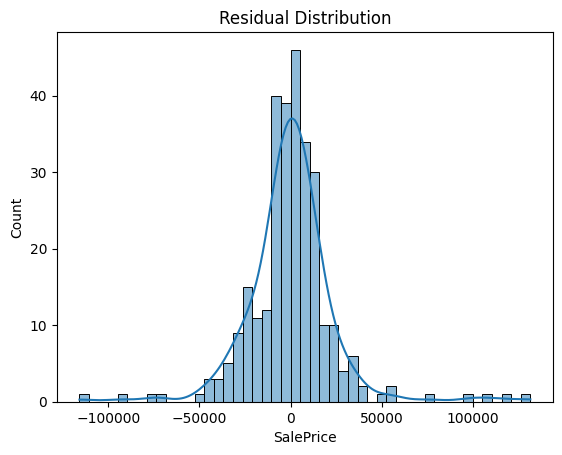

In [121]:
resid = y_test - best_model.predict(X_test)
sns.histplot(resid, kde=True)
plt.title("Residual Distribution")
plt.show()

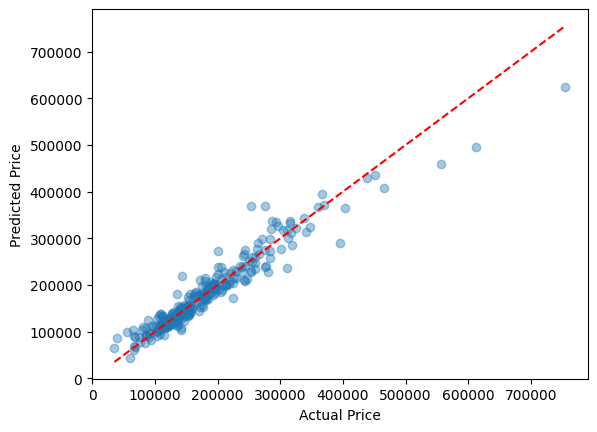

In [123]:
plt.scatter(y_test, best_model.predict(X_test), alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

In [131]:
def bootstrap_prediction_intervals(model, X_train, y_train, X_pred, n_boot=200, alpha=0.05):
    preds = []
    
    # Fit base model once to estimate residuals
    model.fit(X_train, y_train)
    resid = y_train - model.predict(X_train)
    
    for i in range(n_boot):
        X_bs, y_bs = resample(X_train, y_train, random_state=i)
        model.fit(X_bs, y_bs)
        
        pred = model.predict(X_pred)
        noise = np.random.choice(resid, size=len(pred), replace=True)
        preds.append(pred + noise)
    
    preds = np.vstack(preds)
    
    lower = np.percentile(preds, 100 * alpha / 2, axis=0)
    upper = np.percentile(preds, 100 * (1 - alpha / 2), axis=0)
    mean_pred = preds.mean(axis=0)
    
    return mean_pred, lower, upper

In [135]:
mean_pred, lower, upper = bootstrap_prediction_intervals(
    best_model,
    X_train, y_train,
    X_test,
    n_boot=300,
    alpha=0.05  # 95% interval
)

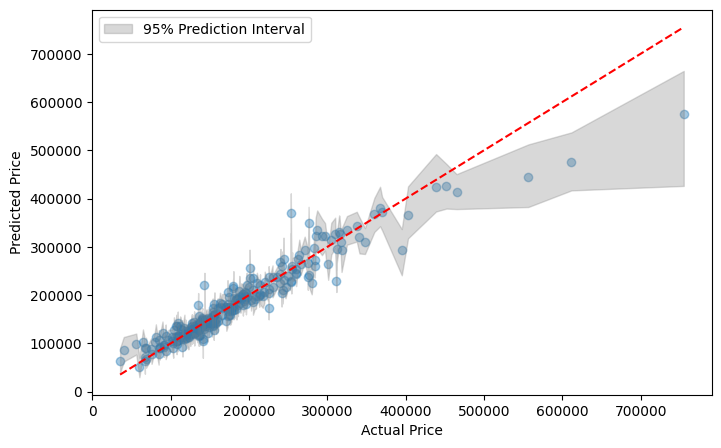

In [136]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, mean_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.fill_between(
    y_test.sort_values(),
    lower[np.argsort(y_test)],
    upper[np.argsort(y_test)],
    color='gray',
    alpha=0.3,
    label='95% Prediction Interval'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

In [137]:
coverage = np.mean((y_test >= lower) & (y_test <= upper))
print("Interval coverage:", coverage)

Interval coverage: 0.8116438356164384
